In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load the CSV file into a pandas DataFrame
df = pd.read_csv('../results/all_results_2023-11-18_11-40-50.csv')

# Set the aesthetics for the seaborn plots
sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=1.5, rc={"lines.linewidth": 2.5})
sns.set_palette("Set2")
plt.rcParams.update({
    "font.family": "serif",
    "xtick.labelsize": 17,
    "ytick.labelsize": 17,
    "axes.titlesize": 18,
    "axes.titleweight": 'bold',
    "axes.labelsize": 19,
    "axes.labelweight": 'bold'
})

# Filter the DataFrame for 'MNIST' or 'FashionMNIST' and epochs > 2
filtered_df = df[(df['dataset_name'].isin(['MNIST', 'FashionMNIST']))]# & (df['epochs'] > 2)]

# Replace NaN values with 0 in the 'regularization_param' column
filtered_df['regularization_param'].fillna(0, inplace=True)
filtered_df['quantization_method'].fillna("none", inplace=True)


/var/folders/rm/shfwj2xd20x65x46ng3xqf9m0000gp/T/ipykernel_2261/2445781511.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['regularization_param'].fillna(0, inplace=True)
/var/folders/rm/shfwj2xd20x65x46ng3xqf9m0000gp/T/ipykernel_2261/2445781511.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['quantization_method'].fillna("none", inplace=True)


In [3]:
filtered_df

,runner_id,model_name,dataset_name,regularization,regularization_param,train_loss,test_loss,train_accuracy,test_accuracy,timestamp,...,batch_size,seed,total_weights,l1_norm,l2_norm,max_weight,min_weight,model_size_mb,quantization_method,pretrained
0,itaishapira,lenet,FashionMNIST,none,0.00,0.309827,0.353007,88.573333,87.12,2023-11-07_08-15-12,...,256,42,128576,9287.631286,70.556494,0.598757,-1.479511,0.490479,none,NaN
1,itaishapira,lenet,MNIST,batch_norm,0.00,0.044411,0.049943,98.648333,98.37,2023-11-06_18-25-02,...,256,42,128664,6889.219768,54.414420,1.489537,-0.245150,0.490814,none,NaN
2,alexo,lenet,MNIST,batch_norm,0.00,0.044571,0.048616,98.623333,98.40,2023-11-18_11-36-58,...,256,42,252263,13489.176332,89.615006,1.489537,-0.246112,0.248196,dynamic_quantization,False
3,alexo,lenet,MNIST,batch_norm,0.00,0.044411,0.049943,98.648333,98.37,2023-11-18_11-31-26,...,256,42,249717,13367.053275,83.675189,1.489537,-0.246112,0.238483,static_quantization,False
5,itaishapira,lenet,FashionMNIST,l2,0.10,2.308342,2.309078,10.000000,10.00,2023-11-07_08-40-30,...,256,42,128576,168.245492,5.663764,0.212620,-0.148728,0.490479,none,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
76,alexo,lenet,MNIST,none,0.00,0.106862,0.093750,96.865000,97.22,2023-11-18_11-31-00,...,256,42,249627,13157.400634,71.083952,0.439490,-0.266337,0.238140,static_quantization,False
77,itaishapira,lenet,MNIST,l1,0.01,4.405729,4.405073,11.236667,11.35,2023-11-06_18-28-59,...,256,42,128576,49.937538,7.331102,0.844597,-0.000659,0.490479,none,NaN
78,itaishapira,lenet,MNIST,layer_norm,0.00,0.041749,0.049787,98.761667,98.34,2023-11-06_18-25-41,...,256,42,137536,11533.770113,138.592388,1.195296,-0.412194,0.524658,none,NaN
79,alexo,lenet,MNIST,layer_norm,0.00,0.041749,0.049787,98.761667,98.34,2023-11-18_11-37-50,...,256,42,261135,18160.915261,173.977642,1.195296,-0.413810,0.282040,dynamic_quantization,False


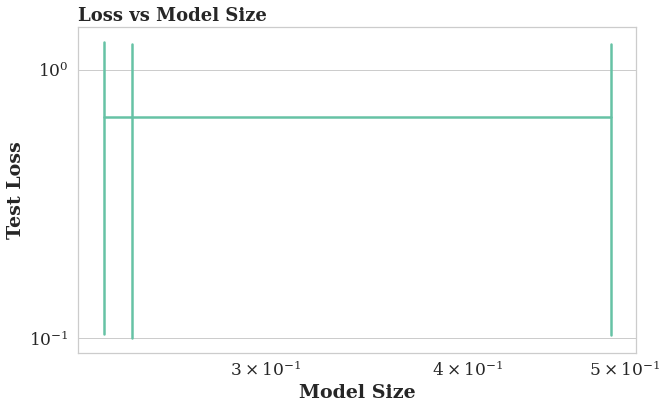

In [15]:
plt.figure(figsize=(10, 6))
plot = sns.lineplot(
    data=filtered_df[(filtered_df.regularization == 'l2') & (filtered_df.dataset_name == "MNIST")],
    x='model_size_mb',
    y='test_loss',
    # hue='quantization_method',
    err_style="bars"
)
plot.set_title('Loss vs Model Size', fontweight='bold', loc='left')
plot.set_xlabel('Model Size', fontweight='bold')
plot.set_ylabel('Test Loss', fontweight='bold')
plt.xscale('log')
plt.yscale('log')
plt.show()

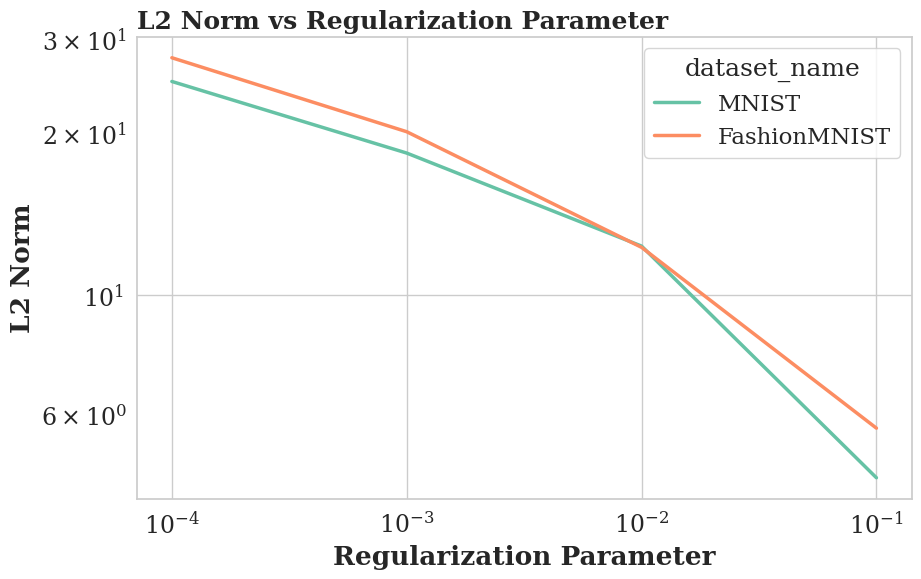

In [14]:
plt.figure(figsize=(10, 6))
plot = sns.lineplot(
    data=filtered_df[filtered_df.regularization == 'l2'],
    x='regularization_param',
    y='l2_norm',
    hue='dataset_name',
)
plot.set_title('L2 Norm vs Regularization Parameter', fontweight='bold', loc='left')
plot.set_xlabel('Regularization Parameter', fontweight='bold')
plot.set_ylabel('L2 Norm', fontweight='bold')
plt.xscale('log')
plt.yscale('log')
plt.show()

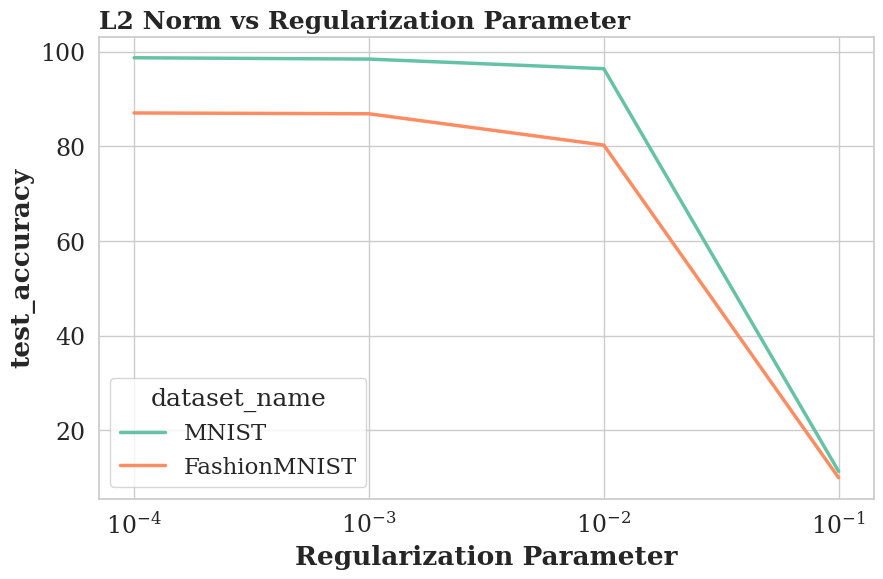

In [23]:
plt.figure(figsize=(10, 6))
plot = sns.lineplot(
    data=filtered_df[filtered_df.regularization == 'l2'],
    x='regularization_param',
    y='test_accuracy',
    hue='dataset_name',
)
plot.set_title('L2 Norm vs Regularization Parameter', fontweight='bold', loc='left')
plot.set_xlabel('Regularization Parameter', fontweight='bold')
plot.set_ylabel('test_accuracy', fontweight='bold')
plt.xscale('log')
#plt.yscale('log')
plt.show()

In [21]:
filtered_df[filtered_df.regularization == 'l2'][['test_accuracy', 'regularization_param']].sort_values('regularization_param')

,test_accuracy,regularization_param
30,98.69,0.0001
47,87.03,0.0001
29,98.41,0.0010
46,86.86,0.0010
28,96.38,0.0100
45,80.25,0.0100
27,11.35,0.1000
44,10.00,0.1000


In [24]:
df

,runner_id,model_name,dataset_name,regularization,regularization_param,train_loss,test_loss,train_accuracy,test_accuracy,timestamp,...,lr,device,batch_size,seed,total_weights,l1_norm,l2_norm,max_weight,min_weight,model_size_mb
0,itaishapira,lenet,MNIST,none,NaN,0.106862,0.093750,96.865000,97.22,2023-11-06_18-24-23,...,0.001,cpu,256,42,128576,6821.780545,44.299252,0.354906,-0.364684,0.490479
1,itaishapira,lenet,MNIST,batch_norm,NaN,0.044411,0.049943,98.648333,98.37,2023-11-06_18-25-02,...,0.001,cpu,256,42,128664,6889.207073,54.414420,1.489537,-0.245150,0.490814
2,itaishapira,lenet,MNIST,layer_norm,NaN,0.041749,0.049787,98.761667,98.34,2023-11-06_18-25-41,...,0.001,cpu,256,42,137536,11533.751559,138.592388,1.195296,-0.412194,0.524658
3,itaishapira,lenet,MNIST,dropout,0.3000,0.111467,0.101370,96.566667,96.68,2023-11-06_18-26-20,...,0.001,cpu,256,42,128576,9273.706537,56.757068,0.371683,-0.404107,0.490479
4,itaishapira,lenet,MNIST,dropout,0.5000,0.156399,0.147546,95.486667,95.56,2023-11-06_18-26-58,...,0.001,cpu,256,42,128576,10089.942562,60.505424,0.319298,-0.370355,0.490479
5,itaishapira,lenet,MNIST,dropout,0.7000,0.509910,0.495203,86.016667,86.82,2023-11-06_18-27-37,...,0.001,cpu,256,42,128576,10357.167816,60.639906,0.356819,-0.338827,0.490479
6,itaishapira,lenet,MNIST,l1,0.1000,6.871712,6.871768,10.441667,10.28,2023-11-06_18-28-16,...,0.001,cpu,256,42,128576,16.458175,0.288702,0.154038,-0.000651,0.490479
7,itaishapira,lenet,MNIST,l1,0.0100,4.405729,4.405073,11.236667,11.35,2023-11-06_18-28-59,...,0.001,cpu,256,42,128576,49.937473,7.331102,0.844597,-0.000659,0.490479
8,itaishapira,lenet,MNIST,l1,0.0010,0.203504,0.184182,93.978333,94.67,2023-11-06_18-29-44,...,0.001,cpu,256,42,128576,433.090295,15.277419,0.416447,-0.389816,0.490479
9,itaishapira,lenet,MNIST,l1,0.0001,0.166344,0.154712,94.961667,95.26,2023-11-06_18-30-27,...,0.001,cpu,256,42,128576,1208.992783,20.065136,0.425115,-0.380133,0.490479
